In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sqlite3
import sys


# Sklearn preprocessing
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectPercentile, mutual_info_regression, VarianceThreshold, SelectFromModel
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor


# Load Data

In [2]:
data_path = os.path.join(os.path.dirname(os.getcwd()), 'data')

In [3]:
data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), 'data', 'data_cpv.csv'))
data.head()

,uid,id,nature,acheteur_id,acheteur_nom,acheteur_siren,titulaire_id,titulaire_typeIdentifiant,titulaire_nom,titulaire_siren,...,origineFrance,lieuExecution_code,lieuExecution_typeCode,idAccordCadre,source_open_data,codeCPV_FR,codeCPV_2,codeCPV_3,codeCPV_4,codeCPV_5
0,210601209000132022_M013,2022_M013,Marché,21060120900013,COMMUNE DE SAINT ETIENNE DE TINEE,210601209.0,38177692100029,SIRET,SERMATECH,381776921.0,...,NaN,06660,Code postal,NaN,data.gouv.fr decp-2024.json,Travaux de construction de bâtiments,45000000,45200000,45210000,45210000
1,217100759000182024RENOCHARP,2024RENOCHARP,Marché,21710075900018,COMMUNE DE CHALMOUX,217100759.0,75203574100038,SIRET,MACON ETANCHEITE,752035741.0,...,0.0,71140,Code postal,NaN,data.gouv.fr decp-2025-01.json,Travaux de charpente et de couverture et trava...,45000000,45200000,45260000,45261000
2,200066231000162022033INFOL00,2022033INFOL00,Marché,20006623100016,CC DES PORTES D'ARIEGE PYRENEES,200066231.0,49459697600014,SIRET,EQUADEX,494596976.0,...,NaN,09100,Code postal,2022033INFOL00,data.gouv.fr decp-2024.json,Services de gestion d'installations pour le dé...,72000000,72500000,72510000,72514000
3,243100518001702024M05,2024M05,Marché,24310051800170,TOULOUSE METROPOLE,243100518.0,59278023300017,SIRET,RIVES & EAUX DU SUD-OUEST,592780233.0,...,0.0,31000,Code postal,NaN,data.gouv.fr decp-2025-04.json,Services d'ingénierie,71000000,71300000,71300000,71300000
4,21590544900017202402401,202402401,Marché,21590544900017,COMMUNE DE SAINT SAULVE,215905449.0,32683156700010,SIRET,ALTOMARE ALTALU,326831567.0,...,NaN,59800,Code postal,NaN,data.gouv.fr decp-2024.json,Serrurerie,44000000,44300000,44310000,44316000


# Preprocess

## Test 1

In [4]:
X = data[['montant', 'procedure', 'dureeMois', 'formePrix', 'attributionAvance',
          'sousTraitanceDeclaree', 'typeGroupementOperateurs', 'tauxAvance','codeCPV_3']]

In [5]:
cpv_3 = data['codeCPV_3'].value_counts()
cpv_3_list = cpv_3[cpv_3 > 200].reset_index()['codeCPV_3']

X = X[X['codeCPV_3'].isin(cpv_3_list)]

X = X[~X['dureeMois'].isna()].copy()

In [6]:
X_train, X_test = train_test_split(
    X,
    test_size=0.2,
    random_state=0,
    stratify=X['codeCPV_3']
)

In [17]:
X_train['codeCPV_3'].value_counts(normalize=True)

codeCPV_3
45200000    0.223714
45400000    0.070237
71200000    0.062651
71300000    0.049815
45100000    0.048588
              ...   
3000000     0.000748
72000000    0.000744
90100000    0.000731
42500000    0.000722
9000000     0.000718
Name: proportion, Length: 124, dtype: float64

In [18]:
X_test['codeCPV_3'].value_counts(normalize=True)

codeCPV_3
45200000    0.223705
45400000    0.070242
71200000    0.062656
71300000    0.049815
45100000    0.048579
              ...   
72000000    0.000748
74100000    0.000748
42500000    0.000731
90100000    0.000731
9000000     0.000713
Name: proportion, Length: 124, dtype: float64

In [7]:
X_train.head()

,montant,procedure,dureeMois,formePrix,attributionAvance,sousTraitanceDeclaree,typeGroupementOperateurs,tauxAvance,codeCPV_3
199888,88595.00,Procédure adaptée,22.0,Forfaitaire,0.0,0.0,Conjoint,0.0,71200000
172101,71500.00,Procédure adaptée,12.0,Unitaire,0.0,0.0,Pas de groupement,NaN,71300000
242551,302157.13,Procédure adaptée,18.0,Unitaire,NaN,NaN,Pas de groupement,0.0,45000000
62627,164829.00,Procédure adaptée,22.0,Unitaire,NaN,NaN,Pas de groupement,0.0,45200000
46199,622941.24,Procédure adaptée,19.0,Forfaitaire,0.0,1.0,Pas de groupement,0.0,45300000


In [8]:
features_imputer_2 = ['attributionAvance', 'sousTraitanceDeclaree']

features_imputer_0 = ['tauxAvance']

# AttributionAvance
imputer_2 = SimpleImputer(strategy='constant', fill_value=2)

# TauxAvance
imputer_0 = SimpleImputer(strategy='constant', fill_value=0)

# All ohe features
ohe_features = ['procedure', 'formePrix', 'typeGroupementOperateurs','codeCPV_3']

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary')

imputer_2_pipe = make_pipeline(imputer_2, ohe)

# Numerical features
numerical_features = ['montant', 'dureeMois']
robust_scaler = RobustScaler()

imputer_0_pipe = make_pipeline(imputer_0, robust_scaler)


preproc_baseline = ColumnTransformer([
                    ('imputer_2', imputer_2_pipe, features_imputer_2),
                    ('imputer_0', imputer_0_pipe, features_imputer_0),
                    ('scale', robust_scaler, numerical_features),
                    ('ohe', ohe, ohe_features)
                    ]).set_output(transform='pandas')


preproc_baseline


ColumnTransformer(transformers=[('imputer_2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value=2,
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['attributionAvance',
                                  'sousTraitanceDeclaree']),
                                ('imputer_0',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('robustscaler',
                                                  RobustScaler())]),
                                 ['tauxAvance']),
                                ('scale', RobustScaler(),
                                 ['montant', 'dureeMois']),
                                ('ohe',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['procedure', 'formePrix',
                                  'typeGroupementOperateurs', 'codeCPV_3'])])

In [9]:
X_train_preproc = preproc_baseline.fit_transform(X_train)
X_test_preproc = preproc_baseline.transform(X_test)

In [10]:
model_if = IsolationForest(n_estimators=100, contamination=0.01, random_state=0)

pipeline = make_pipeline(preproc_baseline, model_if)

pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('imputer_2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value=2,
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['attributionAvance',
                                                   'sousTraitanceDeclaree']),
                                                 ('imputer_0',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['tauxAvance']),
                                                 ('scale', RobustScaler(),
                                                  ['montant', 'dureeMois']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['procedure', 'formePrix',
                                                   'typeGroupementOperateurs',
                                                   'codeCPV_3'])])),
                ('isolationforest',
                 IsolationForest(contamination=0.01, random_state=0))])

In [11]:
pipeline.fit(X_train)

anomalies = pipeline.predict(X_test)

X_test['anomaly'] = anomalies

anomalies = X_test[X_test['anomaly'] == -1]

In [12]:
anomalies.head()

,montant,procedure,dureeMois,formePrix,attributionAvance,sousTraitanceDeclaree,typeGroupementOperateurs,tauxAvance,codeCPV_3,anomaly
68944,4.686318e+08,Procédure avec négociation,120.0,Mixte,0.0,0.0,Conjoint,NaN,45200000,-1
52514,5.857553e+06,Appel d'offres ouvert,17.0,Forfaitaire,1.0,1.0,Solidaire,0.05,45200000,-1
74944,4.240100e+05,Procédure avec négociation,96.0,Unitaire,1.0,1.0,Conjoint,0.05,71300000,-1
121245,6.700000e+04,Appel d'offres ouvert,24.0,Forfaitaire,1.0,0.0,Conjoint,0.30,79300000,-1
174915,8.302237e+04,Procédure adaptée,12.0,Forfaitaire,1.0,0.0,Solidaire,0.30,45300000,-1


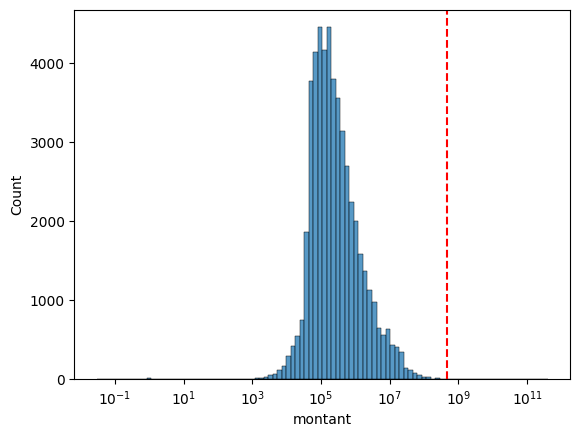

In [26]:
sns_data = X_train[X_train['codeCPV_3'] == 45200000]

sns.histplot(data = sns_data, x = 'montant',log_scale=True, bins = 100)
#plot the line with the anomaly
plt.axvline(x=anomalies.loc[68944,'montant'], color='red', linestyle='--')
plt.show()


In [20]:
sns_data

,montant,procedure,dureeMois,formePrix,attributionAvance,sousTraitanceDeclaree,typeGroupementOperateurs,tauxAvance,codeCPV_3


## Test 2